# 10. cvičenie - VAE

Na tomto cvičení si prejdeme ako funguje VAE (variational autoencoder) a následne si ho implementujeme.

## VAE - princíp

VEA funguje na princípe enkódera a dekódera. Enkódujeme pôvodný obraz, resp. iný vstup do tzv. latentného priestoru. To nám umožňuje vytvoriť redukciu viacrozmerných dát do menšej dimenzie. Dekóder potom dokáže na vstupe zobrať tieto vektory a vygenerovať pôvodný obraz. Toto sa dá využiť napríklad na generáciu obrázkov z distribúcie datasetu.

Enkóder skonštruujeme ako neurónovú sieť, ktorá vráti parametre distribúcie $q_\theta (z | x)$. Z tejto distribúcie môžeme vybrať vzorku $z$. Túto distribúciu budeme modelovať ako normálnu distribúciu a $\theta$ teda bude reprezentovať parametre $\mu$ a $\sigma$. Teda priemer a stredná odchylka.

Dekóder je potom sieť ktorá na vstup prijme vektor $z$ a na výstupe nám generuje distribúciu $q_\phi (x | z)$. Túto distribúciu potom trénujeme pomocou tzv. max likelihood voči trénovacím dátam. Teda pre $i$-ty príklad z trénovacej množiny. $$C = - \mathbb{E}_{z \sim q_\theta(z|x_i)} log(p_\phi (x_i | z))$$

Prakticky je maximalizácia log-likelihood ekvivalentná s minimalizáciou cross-entropy, alebo inej metriky podľa toho čo predpokladáme o distribúcii $p_\phi$.

Takáto optimalizácia však nestačí. Potrebujeme ešte zabezpečiť aby rozdelenie v latentnom priestore bolo zmysluplné. To zabezpečíme pridaním regularizačného člena tzv. Kullback-Leiblerovej divergenice. Táto metrika nám umožňuje spočítať ako veľmi podobné sú dve rôzne distribúcie. Náš cieľ bude aby distribúcia $q_\theta$ bola čo najbližšia normálnej distribúcii $p(z)$. Teoretické zdôvodnenie môžete nájsť [tu](https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/), alebo [tu](https://arxiv.org/pdf/1907.08956.pdf).


$$ C = - \mathbb{E}_{\vec{z} \sim q_\theta(z|\vec{x}_i)} log(p_\phi (\vec{x}_i | \vec{z})) + D_{KL}(q_\theta(\vec{z}|\vec{x}_i) ~||~ p(\vec{z}))$$

$$ D_{KL}(q_\theta(\vec{z}|\vec{x}) ~||~ p(\vec{z})) = \mathbb{E}\left[log(q_\theta(\vec{z}|\vec{x})) - log(p(\vec{z}))\right]$$.

Uvažujeme [normálne distribúcie](https://en.wikipedia.org/wiki/Multivariate_normal_distribution):

$$q_\theta(\vec{z}|\vec{x}) = N(\vec{\mu}, \Sigma),~p(\vec{z}) = N(\vec{0},\mathbb{I})$$, $$\Sigma = diag(\sigma_1^2, \sigma_2^2, ..., \sigma_k^2)$$

$$N(\vec{\mu},\Sigma) = \frac{e^{-\frac{1}{2}(\vec{x} - \vec\mu)^T\Sigma^{-1}(\vec{x} - \vec\mu)}}{\sqrt{2 \pi |\Sigma|}}$$

Pre KL divergenciu normálnych distribúcii [platí](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence):


$$D_{KL}(N(\vec\mu_0, \Sigma_0) || N(\vec\mu_1, \Sigma_1)) = \frac{1}{2} \left( tr(\Sigma_1^{-1} \Sigma_0) + (\vec\mu_1 - \vec\mu_0)^T \Sigma_1^{-1}(\vec\mu_1-\vec\mu_0) - k + ln \frac{|\Sigma_1|}{|\Sigma_0|}\right)$$

Teda:

$$D_{KL}(q_\theta(\vec{z}|\vec{x}) ~||~ p(\vec{z})) = \frac{1}{2}\left( \sum_{i=1}^k \sigma_i + \sum_{i=1}^k \mu_i^2 - k + log\prod_{i=1}^k \frac{1}{\sigma_i^2} \right)$$

$$D_{KL}(q_\theta(\vec{z}|\vec{x}) ~||~ p(\vec{z})) = \frac{1}{2}\sum_{i=1}^k \left(\sigma_i^2 + \mu_i^2 - 1 - log(\sigma_i^2) \right)$$

Z numerických dôvodov je lepšie pracovať v sieti priamo s $log(\sigma_i^2)$ namiesto s $\sigma_i^2$. Ak si zadefinujeme:

$$\lambda_i = log(\sigma_i^2)$$

potom konečne:

$$D_{KL}(q_\theta(\vec{z}|\vec{x}) ~||~ p(\vec{z})) = \frac{1}{2}\sum_{i=1}^k \left(e^{\lambda_i} + \mu_i^2 - 1 - \lambda_i \right)$$


## Ako to teda celé bude fungovať?

$\vec\mu$ aj $\vec\lambda$ sa počítajú na základe prvkov $\vec{x}_i$ v minibatchi. Tj. enkóder (sieť) zoberie na vstupe $\vec{x}_i$ a z neho spočíta $\vec{\mu}$ a $\vec\lambda$. Na základe toho sa ako $\vec{z}$ vyberie vzorka z distribúcie $N(\vec{\mu}, \Sigma)$. Tá sa potom vloží do enkódera (opäť sieť) a dostaneme výsledok $\vec{y}$. Sieť potom trénujeme na minibatchi veľkosti $M$ pomocou loss napr. pomocou cross-entropy:

$$ C = \frac{1}{M} \sum_{i = 1}^M CE\left(\vec{y}(\vec{z} \sim N[\vec{\mu}(\vec{x}_i), \Sigma(\vec{x}_i)]), \vec{x}_i \right) + D_{KL}(\vec{\mu}(\vec{x}_i), \Sigma(\vec{x}_i)) $$ 

Posledná vec, ktorú musíme vyriešiť je ako budeme vyberať vzorky $vec{z}$ z distribúcie $N(\vec{\mu}(\vec{x}_i), \Sigma(\vec{x}_i))$ tak, aby sa nám gradienty spropagovali aj do dekódera. Naštastie sa to dá spraviť pomocou vyberania vzoriek z bežnej normálnej distribúcie:

$$ z_j = \mu_j + \sigma_j \cdot N(0,1) = \mu_j + e^{\frac{\lambda_j}{2}} \cdot N(0,1)$$ 

## Diagram VAE

Teraz budete implementovať sieť podľa tohoto diagramu:

![Alt text](https://raw.githubusercontent.com/kocurvik/edu/master/PNNPPV/supplementary/ntb_images/VAE_MNIST_small.png)

Máme v podstate tri modely, ktoré zdieaľajú niektoré vrstvy. Na konci samozrejme budete musieť trénovať len VAE model a tie ostatné dva môžete použiť neskôr na inferenciu.

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


if torch.cuda.is_available():
    dev = "cuda:0"
    print('Running on GPU {:}'.format(dev))
else:
    dev = "cpu"
    print('Running on CPU')


Running on GPU cuda:0


Tradične si načítame MNIST.

In [ ]:
batch_size = 64

transformer = transforms.Compose([transforms.ToTensor(),
                                  transforms.Lambda(lambda x: torch.flatten(x))])

train_set = torchvision.datasets.MNIST('./data', train=True, transform=transformer, download=True)
test_set = torchvision.datasets.MNIST('./data', train=False, transform=transformer, download=True)

train_loader = torch.utils.data.DataLoader(train_set,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2,
                                          drop_last=True)

test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2,
                                          drop_last=True)

Nastavíme parametre modelu.

In [ ]:
n_z = 2
n_hidden = 512
img_dim = 784

Tu doplnte váš kód.

In [ ]:
class VAE(nn.Module):
  def __init__(self, n_z, n_hidden, img_dim, device):
    '''
    Trieda VAE dedi od triedy nn.Module ktora je base triedou pre vsetky neuronove siete v pytorchi.
    Pri inicializacii zadefinujeme zakladne bloky VAE podla diagramu VAE. 

    :param n_z: Dimenzia latentneho priestoru
    :param n_hidden: Dimenzia skrytych vrstiev
    :param img_dim: Dimenzia vstupu a vystupu (v pripade sedotonoveho obrazku o velkosti 28x28 je img_dim 784)
    :param device: Nazov zariadenia na ktorom sa budu vykonavat vypocty. Napr "cpu" alebo "cuda:0"
    '''
    super(VAE, self).__init__()
    self.n_z = n_z
    self.n_hidden = n_hidden
    self.img_dim = img_dim
    self.device = device

    self.fc_encoder = nn.Linear(img_dim, n_hidden)
    self.fc_mu = nn.Linear(n_hidden, n_z)
    self.fc_sigma = nn.Linear(n_hidden, n_z)

    self.fc_z = nn.Linear(n_z, n_hidden)
    self.fc_decoder = nn.Linear(n_hidden, img_dim)

    self.enc_act = nn.ReLU()
    self.dec_act = nn.ReLU()
    self.out_act = nn.Sigmoid()

  def encode(self, x):
    '''
    :param x: vstupny tensor obrazkou s dimenziou [ batch_size X img_dim ]
    '''
    x = self.enc_act(self.fc_encoder(x))
    mu = self.fc_mu(x)
    sigma = self.fc_sigma(x)
    return mu, sigma

  def decode(self, z):
    '''
    :param z: vstupny tensor vektorou latentneho priestoru s dimenziou [ batch_size X n_z ]
    '''
    x = self.dec_act(self.fc_z(z))
    return self.out_act(self.fc_decoder(x))

  def forward(self, x):
    '''
    Najprv vypocitame mu a sigma (v skutocnosti log(sigma^2)).
    Vygenerujeme nahodny prvok z N(0,1).
    Pomocou reparametrizacneho "triku" dostaneme vektory latentneho priestoru z_i reprezentujuce obrazky minibatchu.
    Vektory z_i pouzijeme ako vstup dekoderu.

    :param x: vstupny tensor s dimenziou [ batch_size X img_dim ]
    '''
    mu, sigma = self.encode(x)
    randn_sample = torch.randn(mu.shape).to(self.device)
    z = mu + torch.exp(sigma/2) * randn_sample
    out = self.decode(z)
    return out, mu, sigma

  def compute_loss(self, inp, out, mu, sigma):
    '''
    Loss pre VAE odvodena z vyssie uvedenych vzorcov.
    Na konci staci predelit iba KL poctom minibatchov a dlzkou vstupneho vektoru.
    F.binary_cross_entropy to uz robi automaticky. 
    Inac vznika problem ako na:
    https://stackoverflow.com/questions/50607516/variational-autoencoder-gives-same-output-image-for-every-input-mnist-image-when

    :param inp: tensor originalnych obrazkov s dimenziou [ batch_size X img_dim ]
    :param out: tensor zrekonstruovanych obrazkov s dimenziou [ batch_size X img_dim ]
    :param mu: tensor strednych hodnoty s dimneziou [ batch_size X n_z ]
    :param sigma: tensor log(sigma^2) s dimneziou [ batch_size X n_z ]
    '''
    CO = F.binary_cross_entropy(out, inp)
    KL = 0.5 * torch.sum(sigma.exp() + mu**2 -1 - sigma)
    M = inp.shape[0]
    C = CO + (KL / (M*self.img_dim))
    return C

  def encode_predict(self, x):
    '''
    Vypocitame vektor z_i latentneho priestoru pomocou x_i
    Pouzivame with torch.no_grad(), aby sa nepocitali gradienty.

    :param x: vstupny tensor obrazkou s dimenziou [ batch_size X img_dim ]
    '''
    with torch.no_grad():
      x = self.enc_act(self.fc_encoder(x))
      mu = self.fc_mu(x)
      sigma = self.fc_sigma(x)
      randn_sample = torch.randn(mu.shape)
      randn_sample = randn_sample.to(self.device)
      z = mu + torch.exp(sigma/2) * randn_sample
    return z

  def decode_predict(self, z):
    '''
    Zrekonstruujeme obrazky pomocou vektorou z_i
    Pouzivame with torch.no_grad(), aby sa nepocitali gradienty.

    :param z: vstupny tensor vektorou latentneho priestoru s dimenziou [ batch_size X n_z ]
    '''
    with torch.no_grad():
      return self.decode(z)

Spustíme trénovanie

In [ ]:
net = VAE(n_z, n_hidden, img_dim, dev)
net.to(dev)
optimizer = optim.Adam(net.parameters(), lr=0.00001)

epochs = 15
for ep in range(1, epochs+1):
  for x, _ in train_loader:
    # vynulujeme gradienty
    optimizer.zero_grad()
    # vypocitame forward pass
    x = x.to(dev)
    out, mu, sigma = net(x)
    # vypocitame chybu
    loss = net.compute_loss(x, out, mu, sigma)
    # spocitame gradienty
    loss.backward()
    # upravime vahy
    optimizer.step()
  print("Epoch: {:} | loss: {:}".format(ep, loss))

net = net.eval()

Epoch: 1 | loss: 0.3077791929244995
Epoch: 2 | loss: 0.28510719537734985
Epoch: 3 | loss: 0.2665119767189026
Epoch: 4 | loss: 0.2641008496284485
Epoch: 5 | loss: 0.2483557164669037
Epoch: 6 | loss: 0.23228195309638977
Epoch: 7 | loss: 0.23465852439403534
Epoch: 8 | loss: 0.2324829399585724
Epoch: 9 | loss: 0.23185107111930847
Epoch: 10 | loss: 0.22986309230327606
Epoch: 11 | loss: 0.23421329259872437
Epoch: 12 | loss: 0.22461755573749542
Epoch: 13 | loss: 0.22471338510513306
Epoch: 14 | loss: 0.22201131284236908
Epoch: 15 | loss: 0.22973847389221191


Po natrénovaní modelu by váš dekóder mal byť schopný generovať obrázky čísiel. Vždy keď spustíte nasledujúcu bunku by ste mali vidieť niečo iné.

tensor([[0.1206, 1.1147]], device='cuda:0')


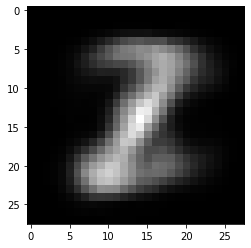

In [ ]:
z_example = torch.randn(1,2).to(dev)
print(z_example)
prediction = net.decode(z_example)
plt.imshow(np.reshape(prediction[0].detach().cpu().numpy(), [28, 28]), cmap='gray')
plt.show()

Môžeme si aj zobraziť ako sú rozložené čísla z testovacej množiny v latentnom priestore. Tu by sme očakávali, že jednotlivé čísla budú v clusteroch pri sebe. A distribúcia všetkých bodov sa bude podobať tej normálnej.

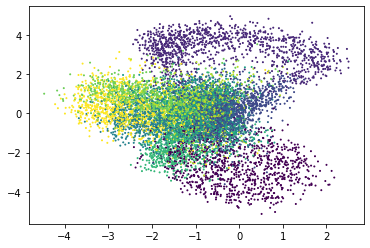

In [ ]:
for i, (x, y) in enumerate(test_loader):
  x = x.to(dev)
  prediction = net.encode_predict(x).detach().cpu().numpy()
  y = y.numpy()
  if i == 0:
    z_list = prediction
    y_list = y
  else:
    z_list = np.row_stack([z_list, prediction])
    y_list = np.row_stack([y_list, y])

plt.scatter(z_list[:, 0], z_list[:, 1], c = y_list, s=1)
plt.show()

Podobne to môžeme skúsiť aj na trénovacej množine.

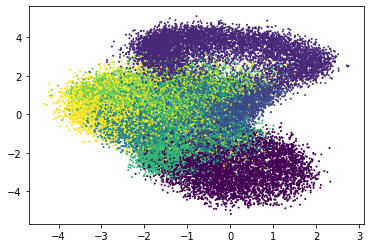

In [ ]:
for i, (x, y) in enumerate(train_loader):
  x = x.to(dev)
  prediction = net.encode_predict(x).detach().cpu().numpy()
  y = y.numpy()
  if i == 0:
    z_list = prediction
    y_list = y
  else:
    z_list = np.row_stack([z_list, prediction])
    y_list = np.row_stack([y_list, y])

plt.scatter(z_list[:, 0], z_list[:, 1], c = y_list, s=1)
plt.show()

Tento skript nám zobrazí ako sa mení výstup z množiny v latentnom priestore.

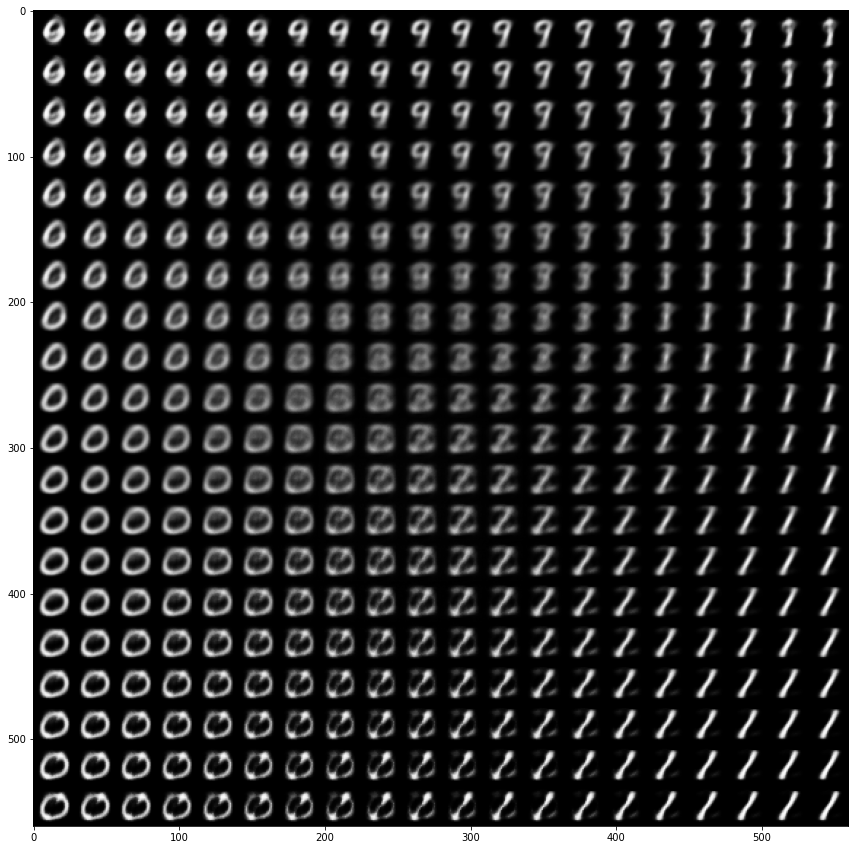

In [ ]:
n_images = 20

final_image = np.zeros([28*n_images,28*n_images])

for i, z1 in enumerate(np.linspace(-3, 3, n_images)):
  for j, z2 in enumerate(np.linspace(-3, 3, n_images)):
    prediction = net.decode_predict(torch.tensor([[z1, z2]]).float().to(dev))
    final_image[i*28:(i+1)*28, j*28:(j+1)*28] = np.reshape(prediction[0].detach().cpu().numpy(), [28, 28])

plt.figure(figsize = (15, 15))
plt.imshow(final_image, cmap='gray')
plt.show()

Rozloženie čísiel si môžeme prezrieť aj v 3D.

Najprv si natrénujeme sieť s dimenziou 3 v latentnom priestore.

In [ ]:
n_z = 3
net = VAE(n_z, n_hidden, img_dim, dev)
net.to(dev)
optimizer = optim.Adam(net.parameters(), lr=0.00001)

epochs = 15
for ep in range(1, epochs+1):
  for x, _ in train_loader:
    optimizer.zero_grad()
    x = x.to(dev)
    out, mu, sigma = net(x)
    loss = net.compute_loss(x, out, mu, sigma)
    loss.backward()
    optimizer.step()
  print("Epoch: {:} | loss: {:}".format(ep, loss))

net = net.eval()

Epoch: 1 | loss: 0.3112708032131195
Epoch: 2 | loss: 0.29558128118515015
Epoch: 3 | loss: 0.2682129442691803
Epoch: 4 | loss: 0.24359829723834991
Epoch: 5 | loss: 0.2436448335647583
Epoch: 6 | loss: 0.22165264189243317
Epoch: 7 | loss: 0.23370249569416046
Epoch: 8 | loss: 0.22230421006679535
Epoch: 9 | loss: 0.23198656737804413
Epoch: 10 | loss: 0.22073368728160858
Epoch: 11 | loss: 0.21408885717391968
Epoch: 12 | loss: 0.19684898853302002
Epoch: 13 | loss: 0.21992988884449005
Epoch: 14 | loss: 0.20177096128463745
Epoch: 15 | loss: 0.2246190905570984


A následne si zobrazíme dáta v 3D.


In [ ]:
for i, (x, y) in enumerate(train_loader):
  x = x.to(dev)
  prediction = net.encode_predict(x).detach().cpu().numpy()
  y = y.numpy()
  if i == 0:
    z_list = prediction
    y_list = y
  else:
    z_list = np.row_stack([z_list, prediction])
    y_list = np.row_stack([y_list, y])

import plotly.graph_objects as go

x, y, z = z_list[:, 0], z_list[:, 1], z_list[:, 2]

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(
        size=1,
        color=y_list.flatten(),
        colorscale='Viridis',
        opacity=0.8
    ))])
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

Pomocou sliderov si môžeme generovať aké čísla chceme. 

In [ ]:
%%capture
%matplotlib inline
from ipywidgets import interact, widgets
from IPython.display import display


def f(z1, z2, z3):
    prediction = net.decode_predict(torch.tensor([[z1/100, z2/100, z3/100]]).float().to(dev))
    ax.imshow(np.reshape(prediction[0].detach().cpu().numpy(), [28, 28]), cmap="gray")
    fig.canvas.draw()
    display(fig)

fig = plt.figure(figsize=(6, 4))
ax  = fig.add_subplot(111)

prediction = net.decode_predict(torch.tensor([[0, 0, 0]]).float().to(dev))
ax.imshow(np.reshape(prediction[0].detach().cpu().numpy(), [28, 28]), cmap="gray")

In [ ]:
interact(f, z1=widgets.IntSlider(min=-600,max=600,step=2,value=0),
            z2=widgets.IntSlider(min=-600,max=600,step=2,value=0),
            z3=widgets.IntSlider(min=-600,max=600,step=2,value=0))

interactive(children=(IntSlider(value=0, description='z1', max=600, min=-600, step=2), IntSlider(value=0, desc…

<function __main__.f>